In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import numpy as np
from collections import OrderedDict

device = 'cuda'if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import numpy as np

def get_customer(ctype=None):
    """Customers come from two feature distributions.
    Class 1: mean age 25, var 5 years, min age 18
             mean ARPU 100, var 15
    Class 2: mean age 45, var 6 years
             mean ARPU 50, var 25
    """
    if ctype is None:
        if np.random.random() > .5: #coin toss
            ctype = 1
        else:
            ctype = 2
    age = 0
    ft = -1
    if ctype == 1:
        while age < 18:
            age = np.random.normal(25, 5)
        while ft < 0:
            ft = np.random.normal(100, 15)
    if ctype == 2:
        while age < 18:
            age = np.random.normal(45, 6)
        while ft < 0:
            ft = np.random.normal(50, 25)
    age = round(age)
    return ctype, (age, ft)

def get_rewards(customer):
    """
    There are three actions:
    promo 1: low value. 10 dollar if accept
    promo 2: mid value. 25 dollar if accept
    promo 3: high value. 100 dollar if accept
    Both groups are unlikely to accept promo 2.
    Group 1 is more likely to accept promo 1.
    Group 2 is slightly more likely to accept promo 3.
    The optimal choice for group 1 is promo 1; 90% acceptance for
    an expected reward of 9 dollars each.
    Group 2 accepts with 25% rate for expected 2.5 dollar reward
    The optimal choice for group 2 is promo 3; 20% acceptance for an expected
    reward of 20 dollars each.
    Group 1 accepts with 2% for expected reward of 2 dollars.
    The least optimal choice in all cases is promo 2; 10% acceptance rate for both groups
    for an expected reward of 2.5 dollars.
    """
    if customer[0] == 1: #group 1 customer
        if np.random.random() > .1:
            reward1 = 10
        else:
            reward1 = 0
        if np.random.random() > .90:
            reward2 = 25
        else:
            reward2 = 0
        if np.random.random() > .98:
            reward3 = 100
        else:
            reward3 = 0
    if customer[0] == 2: #group 2 customer
        if np.random.random() > .75:
            reward1 = 10
        else:
            reward1 = 0
        if np.random.random() > .90:
            reward2 = 25
        else:
            reward2 = 0
        if np.random.random() > .80:
            reward3 = 100
        else:
            reward3 = 0
    return np.array([reward1, reward2, reward3])

def generate_data(n_rows):
    contexts = []
    actions = []
    rewards = []
    opt_actions = []
    reward_vectors = []
    for i in range(n_rows):
        ctype, (age, ARPU) = get_customer()
        reward_vector = get_rewards((ctype, (age, ARPU)))
        action = np.random.randint(0,3)
        reward = reward_vector[action]
        if ctype == 1:
            user_id = np.random.randint(0,20)
            opt_action = 0
        else:
            user_id = np.random.randint(20,40)
            opt_action = 2
        contexts.append([user_id, age, ARPU])
        actions.append(action)
        rewards.append(reward)
        opt_actions.append(opt_action)
        reward_vectors.append(reward_vector)
    return np.array(contexts), np.array(actions), np.array(rewards), np.array(opt_actions), np.array(reward_vectors)


num_data_train = 10240
data_train = generate_data(num_data_train)
num_data_test = 1024
data_valid = generate_data(num_data_test)

In [3]:
class Toydataset(data.Dataset):
    def __init__(self, data_input):
        contexts, actions, rewards, opt_actions, reward_vectors = data_input
        self.contexts = contexts
        self.rewards = rewards
        self.actions = actions
        self.opt_actions = opt_actions
        self.reward_vectors = reward_vectors

    def __getitem__(self, index):
        return self.contexts[index], self.actions[index], self.rewards[index], self.opt_actions[index], self.reward_vectors[index]

    def __len__(self):
        return self.contexts.shape[0]
    
dataset_train = Toydataset(data_train)
dataloader_train = data.DataLoader(dataset=dataset_train, batch_size=64, shuffle=True)
dataset_valid = Toydataset(data_valid)
dataloader_valid = data.DataLoader(dataset=dataset_valid, batch_size=64, shuffle=True)

In [4]:
class WDmodel(nn.Module):
    def __init__(self,         
                 deep_in_dim=63, 
                 action_dim=3, 
                 num_embedding=100, 
                 embed_dim=16, 
                 deep_neurons=[32, 16], 
                 activation=nn.ReLU()):
        
        super(WDmodel, self).__init__()
        
        self.action_dim = action_dim
        self.z_dim = embed_dim + deep_neurons[-1]
        self.activation = activation
        
        self.wide = nn.Embedding(num_embedding, embed_dim)
        
        deep_dict = OrderedDict([])
        in_features = deep_in_dim
        for i, out_features in enumerate(deep_neurons):
            deep_dict[f"fc{i}"] = nn.Linear(in_features, out_features)
            deep_dict[f"activation{i}"] = activation
            in_features = out_features

        self.deep = nn.Sequential(deep_dict)
        # define the final layer
        self.lastlayer = nn.Linear(self.z_dim, self.action_dim)
        
    def forward(self, x):
        
        w_in = x[:,0].long()
        w_out = self.wide(w_in)
        d_in = x[:,1:]
        d_out = self.deep(d_in)
        lastlayer_in = torch.cat((w_out, d_out),dim=1)
        out = self.activation(self.lastlayer(lastlayer_in))
        return out
    
model = WDmodel(deep_in_dim=2, action_dim=3, num_embedding=40, deep_neurons=[128, 64]).to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [5]:
def train(device, model, dataloader_train, dataloader_valid, loss_func, optimizer, num_epoches):
    training_losses = []
    valid_losses = []
    for i in range(num_epoches):
        running_loss = 0.0
        training_average_loss = 0.0
        for contexts, actions, rewards, _, _ in dataloader_train:
            contexts = contexts.float().to(device)
            actions = actions.long().to(device)
            rewards = rewards.float().to(device)
            outputs = model(contexts)
            outs = outputs[range(outputs.shape[0]),actions]
            loss = loss_func(outs, rewards)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * len(contexts)
        training_average_loss = running_loss/float(len(dataloader_train.dataset))
        training_losses.append(training_average_loss)
        
        running_loss = 0.0
        valid_average_loss = 0.0
        for contexts, actions, rewards, _, _ in dataloader_valid:
            contexts = contexts.float().to(device)
            actions = actions.long().to(device)
            rewards = rewards.float().to(device)
            outputs = model(contexts)
            outs = outputs[range(outputs.shape[0]),actions]
            loss = loss_func(outs, rewards)
            running_loss += loss.item() * len(contexts)
        valid_average_loss = running_loss/float(len(dataloader_valid.dataset))
        valid_losses.append(valid_average_loss)
        
        if (i+1) % 10 == 0:
            print("Epoch: {}\t training loss: {}\t validation loss: {}".format(i+1, training_average_loss, valid_average_loss))

    return training_losses, valid_losses

In [6]:
num_epoches = 500
training_losses, valid_losses = train(device, model, dataloader_train, dataloader_valid, loss_func, optimizer, num_epoches)

Epoch: 10	 training loss: 404.66058203577995	 validation loss: 349.6391587257385
Epoch: 20	 training loss: 332.13119757175446	 validation loss: 298.52150535583496
Epoch: 30	 training loss: 329.4204173564911	 validation loss: 303.15284180641174
Epoch: 40	 training loss: 329.35611884593965	 validation loss: 299.01494550704956
Epoch: 50	 training loss: 328.95172383785246	 validation loss: 297.8904995918274
Epoch: 60	 training loss: 328.59171333312986	 validation loss: 297.7688331604004
Epoch: 70	 training loss: 328.6592695713043	 validation loss: 298.60061168670654
Epoch: 80	 training loss: 328.4677109003067	 validation loss: 297.49351263046265
Epoch: 90	 training loss: 327.9155864238739	 validation loss: 296.45688819885254
Epoch: 100	 training loss: 328.63290376663207	 validation loss: 296.54957914352417
Epoch: 110	 training loss: 328.5711685776711	 validation loss: 297.0093367099762
Epoch: 120	 training loss: 328.365360045433	 validation loss: 296.6597979068756
Epoch: 130	 training loss

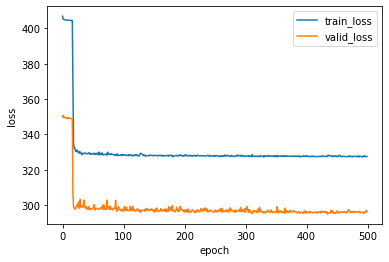

In [7]:
import matplotlib.pyplot as plt
plt.plot(training_losses, label = 'train_loss')
plt.plot(valid_losses, label = 'valid_loss')
plt.legend()
plt.xlabel('epoch')
_ = plt.ylabel('loss')

In [8]:
def evaluate(device, model, dataloader):
    corrects = 0
    cumu_r_p_a = 0.0
    cumu_r_o_a = 0.0
    for contexts, _, _, opt_actions, reward_vectors in dataloader:
        contexts = contexts.float().to(device)
        opt_actions = opt_actions.long().to(device)
        outputs = model(contexts)
        pred_actions = torch.argmax(outputs,dim=1)
        corrects += torch.sum(pred_actions==opt_actions).item()
        cumu_r_p_a += torch.sum(reward_vectors[range(len(reward_vectors)),pred_actions]).item()
        cumu_r_o_a += torch.sum(reward_vectors[range(len(reward_vectors)),opt_actions]).item()
    accuracy = corrects/len(dataloader.dataset)
    print("accuracy of predicted actions: {}\nCumulative reward for predicted actions: {}\nCumulative reward for optimal actions: {}".format(accuracy, cumu_r_p_a, cumu_r_o_a))
    
    #return accuracy, cumu_r_p_a, cumu_r_o_a
    

In [9]:
evaluate(device, model, dataloader_train)

accuracy of predicted actions: 0.99833984375
Cumulative reward for predicted actions: 150220.0
Cumulative reward for optimal actions: 150380.0


In [10]:
evaluate(device, model, dataloader_valid)

accuracy of predicted actions: 0.9990234375
Cumulative reward for predicted actions: 12950.0
Cumulative reward for optimal actions: 12960.0
